## Exploratory Data Analysis (EDA) of Health Expenditure (2000 -2020)

This notebook performs EDA on health-related indicators across countries and time periods using data pulled from a PostgreSQL database. The analysis includes:
- Data Cleaning 
- Descriptive Summary Statistics 
- Correlation Analysis 
- Trend Analysis 
- Clustering 

## 1. Setup and Imports 
We start by importing required libraries for initial data exploration.

In [1]:
# Imports and Database Configuration 
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 2. Database Connection and Query Functions 
Create reusable functions to establish a connection and execute SQL queries: 
- `connect_to_db()`: connects to the PostgreSQL database using the above parameters in Step 1. 
- `run_query()`: executes a SQL query and returns the results as a pandas DataFrame.

In [2]:
def connect_to_db(params):
    print("Attempting to connect to database...")
    try: 
        conn = psycopg2.connect(**params)
        print("Database connection successful!")
        return conn
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

def run_query(query, conn):
    print(f"Running query: {query}")
    try:
        with conn.cursor() as cur:
            cur.execute(query)
            columns = [desc[0] for desc in cur.description]
            data = pd.DataFrame(cur.fetchall(), columns=columns)
        print("Query executed successfully!")
        return data
    except Exception as e:
        print(f"Error running query: {e}")
        return None

## 2.1. Connect to database and pull initial data. 
Here we: 
- Set the database parameters. 
- Connect to the database using `connect_to_db()`.
- Run a test query to preview the table schema. 
- Pull t he main health datase for analysis using `run_query()`.

In [3]:
# Database config
db_params = {
    "dbname": "health_data",
    "user": "postgres",
    "password": "what",
    "host": "localhost",
    "port": 5432
}

# Connect to database
conn = connect_to_db(db_params)

# Preview schema
test_query = "SELECT * FROM health_metrics.health_data LIMIT 10;"
test_df = run_query(test_query, conn)
display(test_df)

# Main data query
health_data_query = """
SELECT * FROM health_metrics.health_data
WHERE indicator_id IN (1,3,4,6,7,8,11,14,18,19)
  AND value IS NOT NULL;
"""
health_data_df = run_query(health_data_query, conn)
health_data_df.head()

# Pull metadata tables
countries_df = pd.read_sql("SELECT * FROM health_metrics.countries", conn)
regions_df = pd.read_sql("SELECT * FROM health_metrics.regions", conn)
indicators_df = pd.read_sql("SELECT * FROM health_metrics.indicators", conn)

Attempting to connect to database...
Database connection successful!
Running query: SELECT * FROM health_metrics.health_data LIMIT 10;
Query executed successfully!


,id,country_id,indicator_id,year,value,region_id
0,60529,278,3,2000,NaN,2
1,60530,278,4,2000,NaN,2
2,60531,278,5,2000,NaN,2
3,60532,278,1,2000,NaN,2
4,60533,278,2,2000,NaN,2
5,60534,300,3,2000,207.309030,7
6,60535,300,4,2000,96.460725,7
7,60536,300,5,2000,107.416066,7
8,60537,300,1,2000,3487.586350,7
9,60538,300,2,2000,3166.147500,7


Running query: 
SELECT * FROM health_metrics.health_data
WHERE indicator_id IN (1,3,4,6,7,8,11,14,18,19)
  AND value IS NOT NULL;

Query executed successfully!


/var/folders/7r/4rng20_d3078xb_q6_2l1ll40000gn/T/ipykernel_45160/3956137789.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  countries_df = pd.read_sql("SELECT * FROM health_metrics.countries", conn)
/var/folders/7r/4rng20_d3078xb_q6_2l1ll40000gn/T/ipykernel_45160/3956137789.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  regions_df = pd.read_sql("SELECT * FROM health_metrics.regions", conn)
/var/folders/7r/4rng20_d3078xb_q6_2l1ll40000gn/T/ipykernel_45160/3956137789.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy

## 3. Data Inspection and Cleaning
This function gives us a first look at the dataset, including schema, column types, and missing values. To resolve missing values, we drop those rows in the 'value' column. We also group by country, indicator, and year to resolve duplicates by taking the mean.

In [4]:
def inspect_data(df): 
    print("\nInspecting the data...")
    print(df.info())
    print(df.describe())
    print("Missing values by column:\n", df.isnull().sum())
    return df.dropna(subset=["value"])

# Clean the data
health_data_df = inspect_data(health_data_df)

# Handle duplicates
health_data_df = health_data_df.groupby(["country_id", "indicator_id", "year"], as_index=False)["value"].mean()


Inspecting the data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39892 entries, 0 to 39891
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            39892 non-null  int64  
 1   country_id    39892 non-null  int64  
 2   indicator_id  39892 non-null  int64  
 3   year          39892 non-null  int64  
 4   value         39892 non-null  float64
 5   region_id     39892 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 1.8 MB
None
                  id    country_id  indicator_id          year         value  \
count   39892.000000  39892.000000  39892.000000  39892.000000  3.989200e+04   
mean   103200.561441    292.445077      9.084528   2010.059135  3.944948e+04   
std     25010.308042     56.166411      5.902564      6.054853  4.613791e+05   
min     60534.000000    196.000000      1.000000   2000.000000  5.934824e-02   
25%     77529.750000    244.000000      4.000000   2005.000000  3.994

## 4. Descriptive Statistics 
We compute yearly summary statistics (mean, median, etc.) over time for two groups: 
- Aggregate health expenditure indicators (IDs: 3, 4, 5)
- Per capita health expenditure indicators (IDs: 7, 8, 11)

In [5]:
def descriptive_analysis(df):
    print("\nCalculating descriptive statistics...")
    try:
        agg_stats = df[df["indicator_id"].isin([3,4,5])].groupby(["indicator_id", "year"])["value"].agg(["mean", "median", "min", "max", "std"])
        per_capita_stats = df[df["indicator_id"].isin([7,8,11])].groupby(["indicator_id", "year"])["value"].agg(["mean", "median", "min", "max", "std"])
        print("Descriptive stats calculated.")
        return agg_stats, per_capita_stats
    except Exception as e:
        print(f"Error: {e}")
        return None
    
# Run descriptive stats 
agg_stats, per_capita_stats = descriptive_analysis(health_data_df)
display(agg_stats)
display(per_capita_stats)


Calculating descriptive statistics...
Descriptive stats calculated.


mean       median       min           max  \
indicator_id year                                                      
3            2000  15337.904497   423.805855  0.604484  1.280346e+06   
             2001  15945.423828   455.144152  2.508886  1.393446e+06   
             2002  17142.913338   475.696471  0.834938  1.529567e+06   
             2003  19393.138048   567.078649  0.985859  1.661824e+06   
             2004  21591.790860   674.712088  2.042690  1.777752e+06   
             2005  23210.136935   746.865067  1.595231  1.901045e+06   
             2006  24925.914983   859.999559  2.868313  2.032105e+06   
             2007  27638.764535  1070.526331  2.529744  2.159312e+06   
             2008  30315.313648  1240.058077  3.071380  2.246088e+06   
             2009  31060.256469  1332.840109  3.456182  2.345544e+06   
             2010  32691.816522  1430.634034  2.318275  2.437516e+06   
             2011  35657.679839  1557.065389  4.301337  2.517798e+06   
             2012  36431.485171  1632.967708  2.104918  2.620099e+06   
             2013  37166.067464  1684.226330  2.507548  2.692589e+06   
             2014  38527.566511  1790.767063  2.965292  2.842182e+06   
             2015  37420.300581  1543.119415  2.041813  3.000644e+06   
             2016  38584.129609  1647.812025  1.890547  3.139123e+06   
             2017  40348.962394  1664.897111  2.287134  3.263040e+06   
             2018  42358.944868  1801.072030  2.489930  3.411631e+06   
             2019  43560.411283  1890.632241  2.209778  3.562338e+06   
             2020  47023.963178  2037.915773  2.609161  3.962160e+06   
4            2000   8807.122132   183.403410  0.595144  5.681854e+05   
             2001   9144.920762   193.392975  1.986078  6.315644e+05   
             2002   9823.798997   204.703978  0.823239  6.913777e+05   
             2003  11217.683093   245.284479  0.871030  7.473990e+05   
             2004  12620.586817   270.948942  1.390619  8.075003e+05   
             2005  13548.431266   329.226876  1.111054  8.645229e+05   
             2006  14551.253427   349.883332  0.713732  9.410158e+05   
             2007  16220.661152   420.800518  2.001213  1.000630e+06   
             2008  18105.711725   462.461584  2.299470  1.066705e+06   
             2009  18756.983052   509.784687  2.504877  1.139735e+06   
             2010  19717.295919   564.610182  1.859012  1.193419e+06   
             2011  21735.649975   626.544449  3.374911  1.237148e+06   
             2012  22051.616204   626.830253  1.720836  1.279850e+06   
             2013  22437.747733   607.353258  1.771076  1.333386e+06   
             2014  23444.957638   657.643730  1.881075  1.443525e+06   
             2015  22626.450588   604.518123  1.352883  1.542097e+06   
             2016  23291.829632   654.194560  1.341851  1.607974e+06   
             2017  24278.059052   661.407164  1.458883  1.670809e+06   
             2018  25562.847117   695.612144  1.665144  1.756903e+06   
             2019  26289.150941   725.439812  1.610967  1.847749e+06   
             2020  29936.914019   829.214449  1.788326  2.260086e+06   

                             std  
indicator_id year                 
3            2000   98993.046168  
             2001  106370.760425  
             2002  115927.479005  
             2003  125990.292134  
             2004  135363.837908  
             2005  144285.985369  
             2006  153751.613507  
             2007  163891.813888  
             2008  171688.501483  
             2009  179211.994394  
             2010  186040.541362  
             2011  194409.400023  
             2012  201698.767434  
             2013  205545.286060  
             2014  216261.859030  
             2015  225803.393333  
             2016  236057.069534  
             2017  245069.157531  
             2018  256525.372106  
             2019  267655.958927  
             2020  296530.735495  
4            2000   48646.125930  
             2001 

mean      median       min          max          std
indicator_id year                                                            
7            2000  444.917140  105.534737  4.472150  4548.554688   782.924674
             2001  460.481636  114.460827  4.627007  4901.675293   807.938232
             2002  495.365513  124.646210  4.175786  5327.937012   900.357739
             2003  593.190502  142.212021  5.709842  5732.243652  1095.844299
             2004  680.860957  167.275864  5.738599  6071.844238  1251.581963
...                       ...         ...       ...          ...          ...
11           2016  317.362701  105.857356  2.873824  6145.289366   632.755668
             2017  332.177617  109.009730  2.868779  6248.713549   651.933126
             2018  346.080634  113.566855  3.236586  6367.010857   670.086834
             2019  345.423148  118.765883  3.596821  6414.231198   673.874867
             2020  333.190142  115.646266  3.512782  6632.953564   676.072239

[63 rows x 5 columns]

## 5. Time Series Trend Visualization 
This function visualizes indicator trends across years to uncover temporal patterns in the data.
- First plot: aggregate expenditure indicators
- Second plot: per capita indicators


Plotting trends over time for Aggregate Health Expenditure Trends...


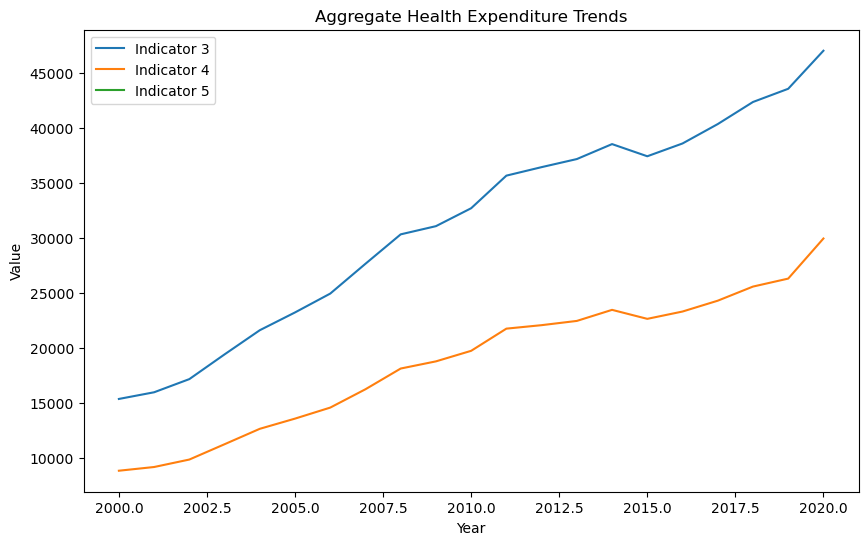


Plotting trends over time for Per Capita Health Expenditure Trends...


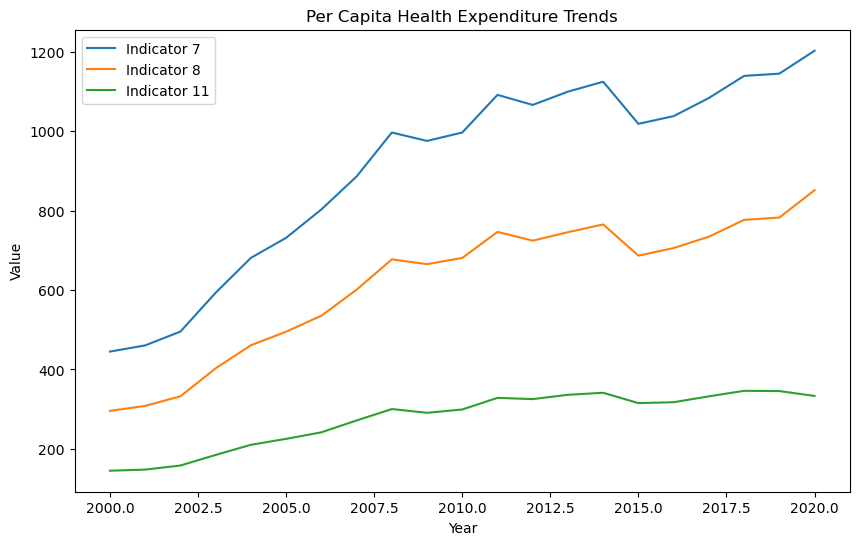

In [6]:
def plot_trends(df, indicators, title):
    print(f"\nPlotting trends over time for {title}...")
    try:
        plt.figure(figsize=(10,6))
        for ind in indicators: 
            subset = df[df["indicator_id"] == ind].groupby("year")["value"].mean()
            plt.plot(subset.index, subset.values, label=f"Indicator {ind}")
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.legend()
        plt.title(title)
        plt.show()
    except Exception as e:
        print(f"Error: {e}")

# Plot aggregate trends
plot_trends(health_data_df, indicators=[3, 4, 5], title="Aggregate Health Expenditure Trends")

# Plot per capita trends
plot_trends(health_data_df, indicators=[7, 8, 11], title="Per Capita Health Expenditure Trends")

## 6. Correlation Analysis 
We create a pivot table of indicators per country and compute a correlation matrix across selected indicators:
- Economic factors (IDs: 1, 6)
- Health expenditure (IDs: 3, 7, 14)
- Health outcomes (18, 19)


Performing correlation analysis...


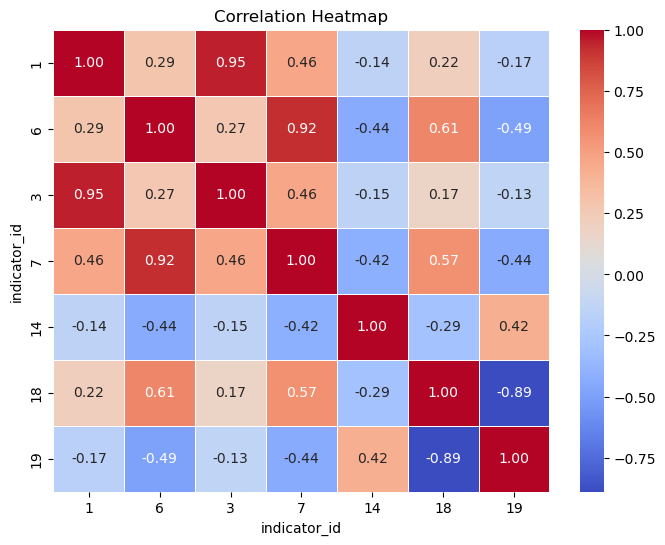

In [7]:
def correlation_heatmap(df_pivot, indicators, title="Correlation Heatmap"):
    try:
        subset = df_pivot[indicators].dropna()
        corr_matrix = subset.corr()
        plt.figure(figsize=(8,6))
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
        plt.title(title)
        plt.show()
        return corr_matrix
    except Exception as e:
        print(f"Error: {e}")
        return None

def correlation_analysis(df, subset_indicators):
    print("\nPerforming correlation analysis...")
    try:
        if df.duplicated(subset=["country_id", "indicator_id"]).any():
            df = df.groupby(["country_id", "indicator_id"], as_index=False)["value"].mean()
        df_pivot = df.pivot(index="country_id", columns="indicator_id", values="value")
        indicators = [i for group in subset_indicators.values() for i in group]
        return correlation_heatmap(df_pivot, indicators)
    except Exception as e:
        print(f"Error: {e}")
        return None

# Subsets of indicators
subset_indicators = {
    "Economic Factors": [1, 6],
    "Health Expenditure": [3, 7, 14],
    "Health Outcomes": [18, 19]
}

# Run correlation
corr_matrix = correlation_analysis(health_data_df, subset_indicators)

## 7. Clustering Analysis 
We apply KMeans clustering to grouup of a sample of 5 countries by: 
- GDP per capita (ID: 6)
- CHE per Capita (ID: 7)
- Life expectancy (ID: 18)

This helps us identify countries with similar profiles based on economic and health indicators.

/var/folders/7r/4rng20_d3078xb_q6_2l1ll40000gn/T/ipykernel_45160/1780879225.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot = df_filtered.pivot(index=["country_id", "year"], columns="indicator_id", values="value").fillna(method='ffill')


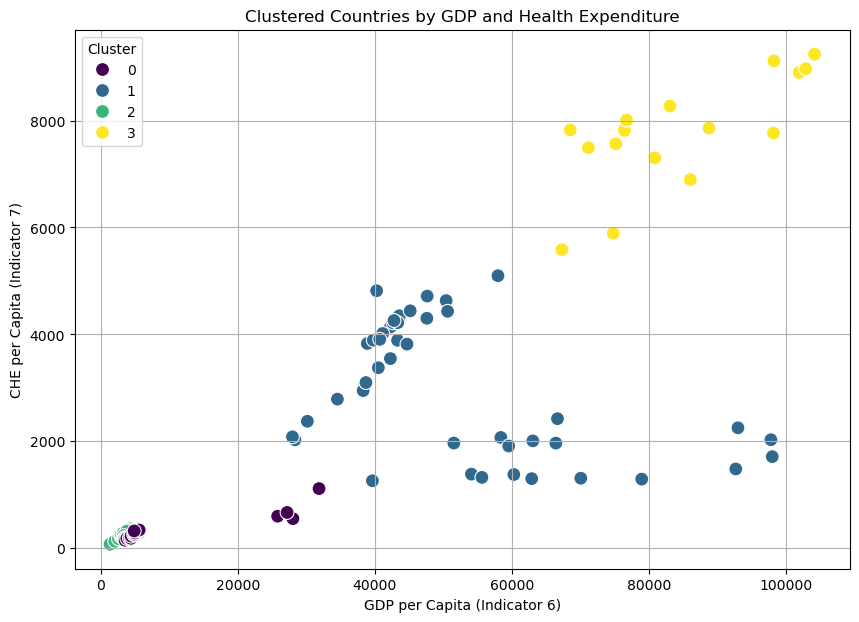

In [8]:
def cluster_data(df, num_clusters=4):
    try:
        if df.duplicated(subset=["country_id", "indicator_id", "year"]).any():
            df = df.groupby(["country_id", "indicator_id", "year"], as_index=False)["value"].mean()
        selected_indicators = [6, 7, 18]
        df_filtered = df[df["indicator_id"].isin(selected_indicators)]
        sampled_country_ids = pd.Series(df["country_id"].unique()).sample(5, random_state=42)
        df_filtered = df_filtered[df_filtered["country_id"].isin(sampled_country_ids)]
        df_pivot = df_filtered.pivot(index=["country_id", "year"], columns="indicator_id", values="value").fillna(method='ffill')
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_pivot)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        df_pivot["Cluster"] = kmeans.fit_predict(df_scaled)
        return df_pivot
    except Exception as e:
        print(f"Error: {e}")
        return None

# Run clustering
clustered_df = cluster_data(health_data_df)

# Optional: visualize GDP vs CHE per capita colored by cluster
if clustered_df is not None:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=clustered_df, x=6, y=7, hue="Cluster", palette="viridis", s=100)
    plt.xlabel("GDP per Capita (Indicator 6)")
    plt.ylabel("CHE per Capita (Indicator 7)")
    plt.title("Clustered Countries by GDP and Health Expenditure")
    plt.grid(True)
    plt.show()

## 8. Export tables to CSV 
This section prepares and exports three clean `.csv.` files containing enriched, analysis-ready health expenditure data. Each export includes:
- Aggregated indicators (CHE total, government expenditure): `agg_stats_final.csv`
- Per Capita Indicators (CHE per capita, government, out-of-pocket): `per_capita_stats_final.csv`
- Pivoted indicators for clustering: `ml_clusters_final.csv`

All tables are merged with metadata including: 
- `country_id`, `region_id`
- `country_name`, `region`, `region_id`
- `indicator_id`, `indicator_name`
- `loaded_at` timestamp 

Note: `indicator_id = 5` (Private CHE) was excluded from export due to lack of data coverage in the source.

Output directory: `health-expenditure/final_datasets/` 


In [15]:
from datetime import datetime
import os
output_directory = "../final_datasets"
os.makedirs(output_directory, exist_ok=True)

# Filter and subset indicators 
agg_data_df = health_data_df[health_data_df["indicator_id"].isin([3, 4])]
per_capita_df = health_data_df[health_data_df["indicator_id"].isin([7, 8, 11])]

# COUNTRY-LEVEL AGG STATS 
agg_stats = agg_data_df.groupby(
    ["country_id", "indicator_id", "year"]
)["value"].agg(["mean", "median", "min", "max"]).reset_index()

# COUNTRY-LEVEL PER CAPITA STATS
per_capita_stats = per_capita_df.groupby(
    ["country_id", "indicator_id", "year"]
)["value"].agg(["mean", "median", "min", "max"]).reset_index()

# COUNTRY-LEVEL CLUSTERING PIVOT 
df_country_pivot = health_data_df.pivot_table(
    index=["country_id", "year"],
    columns="indicator_id",
    values="value"
).reset_index()

clustered_df = df_country_pivot.copy()

# Merge country metadata into all country-level tables 
metadata_cols = ["country_id", "country_name", "region_id", "region", "sub_region"]

agg_stats = agg_stats.merge(countries_df[metadata_cols], on="country_id", how="left")
per_capita_stats = per_capita_stats.merge(countries_df[metadata_cols], on="country_id", how="left")
clustered_df = clustered_df.merge(countries_df[metadata_cols], on="country_id", how="left")

# Merge indicator names into aggregate + per capita tables
agg_stats = agg_stats.merge(indicators_df[["indicator_id", "indicator_name"]], on="indicator_id", how="left")
per_capita_stats = per_capita_stats.merge(indicators_df[["indicator_id", "indicator_name"]], on="indicator_id", how="left")

# Add timestamps
now = datetime.now()
agg_stats["loaded_at"] = now
per_capita_stats["loaded_at"] = now
clustered_df["loaded_at"] = now

# Export to CSV 
agg_stats.to_csv(f"{output_directory}/agg_stats_final.csv", index=False)
per_capita_stats.to_csv(f"{output_directory}/per_capita_stats_final.csv", index=False)
clustered_df.to_csv(f"{output_directory}/ml_clusters_final.csv", index=False)

print("All final tables exported as CSV with country_id, region_id, indicator_id, and full metadata.")


All final tables exported as CSV with country_id, region_id, indicator_id, and full metadata.


## Summary: Key Insights from EDA 
- Cleaned and deduplicated the health dataset from the database.
- Generated descriptive statistics for aggregate and per capita indicators. 
- Observed strongtemporal trends in health expenditures and outcomes. 
- Computed correlation matrices between economic factors, spending, and outcomes. 
- Clustered 5 sampled countries into health-spending groups using KMeans. 

This EDA lays the foundation for running regression and forecasting models to analyze causal relationships between health spending and health outcomes across countries and time.